In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab_Notebooks/perturbation_metric_test
!pip install anndata 
!pip install git+https://github.com/theislab/scgen.git
!pip install matplotlib
!pip install scanpy


Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/perturbation_metric_test
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 5.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/theislab/scgen.git to /tmp/pip-req-build-1_5tcudu
  Running command git clone --filter=blob:none --quiet https://github.com/theislab/scgen.git /tmp/pip-req-build-1_5tcudu
  Resolved https://github.com/theislab/scgen.git to commit 06084773e56cad0dec340138441dee47a39af752
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.3/330.3 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [17]:
import anndata
import scanpy as sc
import scgen
import pandas as pd  
import numpy as np
import torch
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

font = {'family' : 'Arial',
        'size'   : 14}
train = sc.read("./data/PapalexiSatija2021_eccite_RNA.h5ad")
train.layers['counts'] = train.X.copy()
sc.pp.log1p(train)
sc.pp.highly_variable_genes(train, n_top_genes=10, subset=True, min_mean=.1)
train.X = train.layers['counts']


from scvi import settings

def log_zinb_positive(
    x: torch.Tensor, mu: torch.Tensor, theta: torch.Tensor, pi: torch.Tensor, eps=1e-8
):
    """Log likelihood (scalar) of a minibatch according to a zinb model.
    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant
    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(
            1, theta.size(0)
        )  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)

    res = mul_case_zero + mul_case_non_zero

    return res

from typing import Union
import jax.numpy as jnp

def log_nb_positive(
    x: Union[torch.Tensor, jnp.ndarray],
    mu: Union[torch.Tensor, jnp.ndarray],
    theta: Union[torch.Tensor, jnp.ndarray],
    eps: float = 1e-8,
    log_fn: callable = torch.log,
    lgamma_fn: callable = torch.lgamma,
):
    """Log likelihood (scalar) of a minibatch according to a nb model.
    Parameters
    ----------
    x
        data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    log_fn
        log function
    lgamma_fn
        log gamma function
    """
    log = log_fn
    lgamma = lgamma_fn
    log_theta_mu_eps = log(theta + mu + eps)
    res = (
        theta * (log(theta + eps) - log_theta_mu_eps)
        + x * (log(mu + eps) - log_theta_mu_eps)
        + lgamma(x + theta)
        - lgamma(theta)
        - lgamma(x + 1)
    )

    return res

In [10]:
# print(train.X.shape)
# train.layers['counts'] = train.X.copy()

# sc.pp.subsample(train,n_obs=100)
# train.X = train.layers['counts']



In [21]:
from statsmodels.discrete.count_model import (ZeroInflatedNegativeBinomialP, ZeroInflatedPoisson,
                                              ZeroInflatedGeneralizedPoisson)

import matplotlib.pyplot as plt
import statsmodels.api as sm 
from joblib import Parallel,delayed
import torch
import torch.nn.functional as F
def data_prep(adata,conditions=None,sample_ctrl=False):
    """
    param
    -----------
    adata
    return_mean: bool variable True if we want to compute mean of sampled data per cell to
    find statistic between mean of data from sample1 and sample2
    output: the sampled data from sample1 and sample2 of type array
    """
    control = adata[adata.obs["perturbation"] == conditions["x"]]
    stim = adata[adata.obs["perturbation"] == conditions["y"]]

    #fix the number of rows of sampled data as the minimum number of rows between sample1,sample2
    n=np.minimum(control.shape[0],stim.shape[0])

    # sc.pp.subsample(adata,n_obs=n,ramdom_state=0)
    

    y,_ = sample_obs(stim,n)
    # y=adata[adata.obs["perturbation"] == conditions["y"]]
        
    
    y=y.toarray() 
    
    return y

def dist_based(x,y):
    """
    transpose the data so that we can compute static between genes (columns)
    """
    m=np.minimum(x.shape[0],y.shape[0])
    x=x.T[:,:m]#delete .toarray()
    y=y.T[:,:m]
    return x,y

def sample_obs(adata,size_n):
    """
    params 
    -------------
    sample for all control and stim pairs 
    size_n:the number of rows we will consider in comparison
    output x,y in sparse matrix form
    which is sample1 and sample2 drawn from two specified codition
    """

    x = adata.X
    #print(x.shape)(16893, 6998)
    n_rows=x.shape[0]
    
    df = pd.DataFrame({'x':np.arange(n_rows)})
    #shuffle the data index
    # x_sample1=df['x'].sample(frac=1, replace=False).values[:size_n]
    # x_sample2=df['x'].sample(frac=1, replace=False).values[:size_n]
    x_sample1=df['x'].values[:size_n]
    x_sample2=df['x'].values[:size_n]
    
    return x[x_sample1,:], x[x_sample2,:]

import random

def subset(alist, idxs):
    '''
        use idxs to subset alist
        alist: list
        idxs: list
    '''
    sub_list = []
    for idx in idxs:
        sub_list.append(alist[idx])

    return sub_list

def split_list(alist, group_num=3, shuffle=True, retain_left=False):
    '''
        split data into 3 subset and let each subset contains the len(alist)//group number of elements
        shuffle: whether shuffle the splitted data, default: True
        retain_left: if list alist is splited into the number of group_num subset and there is some element remain，
        whether take the remaining elements as a subset
    '''

    index = list(range(len(alist))) 

    
    if shuffle: 
        random.shuffle(index) 
    
    elem_num = len(alist) // group_num 
    sub_lists = {}
    
   
    for idx in range(group_num):
        start, end = idx*elem_num, (idx+1)*elem_num
        sub_lists[str(idx)] = subset(alist, index[start:end])
    
  
    if retain_left and group_num * elem_num != len(index): 
        sub_lists[str(idx+1)] = subset(alist, index[end:])
    
    return sub_lists



def sample_control_control(adata,size_n):
    """
    the sampling for ctrl and ctrl
    split the data into three samples
    shuffle the three samples
    return two data set have maximum between-sample distance
    
    """
    x = adata.X
    n_rows=x.shape[0]
    index_dict=split_list(range(n_rows))# in form {0: [1,2,3],1:[3,44,2...],3:[]}
    sample1=x[index_dict['0'],:size_n].toarray()
    sample2=x[index_dict['1'],:size_n].toarray()
    sample3=x[index_dict['2'],:size_n].toarray() 
    
    
    return sample1, sample2, sample3 

def process_item_alpha(i,x,if_nb):
    # plt.hist(x[i],bins=30)
    # plt.yscale('log')
    # plt.show()
    
    # print(all(elem == 0 for elem in x[i]))
    print("gene",i)

    if all(elem == 0 for elem in x[i]):
        return None 

    else:
        one=np.ones_like(x[i])
        if if_nb:
          model=sm.NegativeBinomialP(x[i],one).fit()
          index=1
        else:
          model=ZeroInflatedNegativeBinomialP(x[i],one).fit()
          index=2
        if model.params[index]>0:
            # print(model.summary())
            return model.params[index]
        else:
            return None 
    
def process_item_const(i,x,if_nb):
    # plt.hist(x[i],bins=30)
    # plt.yscale('log')
    # plt.show()
    
    # print(all(elem == 0 for elem in x[i]))
    print("gene",i)

    if all(elem == 0 for elem in x[i]):
        return None 

    else:
        one=np.ones_like(x[i])
        if if_nb:
          model=sm.NegativeBinomialP(x[i],one).fit()
          index=1
        else:
          model=ZeroInflatedNegativeBinomialP(x[i],one).fit()
          index=2
        if model.params[index]>0:
        # print(model.summary())
            return model.params[index-1]
        else:
            return None 

def process_per_batch(x,num_from,num_to,if_nb):
    x=x[num_from:num_to,:]

    alpha=Parallel(n_jobs=-1,backend="multiprocessing")(
        delayed(process_item_alpha)(i,x,if_nb)for i in range(x.shape[0])
    )

    const=Parallel(n_jobs=-1,backend="multiprocessing")(
        delayed(process_item_const)(i,x,if_nb)for i in range(x.shape[0])
    ) 
    return alpha,const    


In [36]:
from scipy import stats
import seaborn as sns
def test_get_data(zinb,train,metric_str):
    """
    fn: the function to get datasets after sampling before we fit the gene in sample1 and sample2
    
    """
    list_stim=list(train.obs['perturbation'].unique())
    list_stim.remove('control')
    conditions={"x":"control","y":"stim"}
    control = train[train.obs["perturbation"] == conditions["x"]]
    difference=[]
    if_stim=['stim']*len(list_stim)
    # sample1 is always sampled from control and sample2 is sampled from 99 different stim 
    #use prep_data to sample respectively 
    sample1,sample2,sample3=sample_control_control(control,control.shape[0]) 
   
    for stim in list_stim:
        conditions["y"]=str(stim)
        # print(conditions)
        out1=zinb(train,sample1,conditions,str(stim))
        out2=zinb(train,sample2,conditions,str(stim))
        out3=zinb(train,sample3,conditions,str(stim))
        out=(out1+out2+out3)/3
        print("data:",out)
        difference.append(out)
        
    
    #lastly,for (ctrl,ctrl) where we apply a different sampling method, get three points 
    conditions["y"]="control"
    print(conditions)
    
    pairs={}
    pairs[0]=(sample1,sample2)
    pairs[1]=(sample1,sample3)
    pairs[2]=(sample2,sample3)
     
    for i in range(3):
        (x,y)=pairs[i]
        out=zinb(adata=train,ctrl=None,conditions=conditions,stim_str='control'+str(i),sample_ctrl=True,ctrl1=x,ctrl2=y)
        print(" data for (contrl, control):",out)
        difference.append(out)

    zero=['control']*3
    if_stim=if_stim + zero
    metric=[metric_str]*len(if_stim)
        
    return difference,if_stim,metric  

def compute_log_zinb(x,const_x,alpha_x,if_nb):
    # print("mean:",np.mean(x))
    # print("variance:",np.var(x))
    # print("dispersion param:",alpha_x)
    mu=np.exp(const_x)
    theta=1/alpha_x
    # p=1/(1+theta)*mu
    p=mu*theta/(1+theta)
    # p=1/(1+np.exp(const_x)*alpha_x)
    nan=0
    if 1-p<=0 or p<=0:
      most_frequent=0
      nan+=1
    else:
      logit=np.log((1-p)/p)
      # n=np.exp(const_x)*p/(1-p)
     
      n=1/alpha_x*mu
      # sns.set_theme()
      
      # xplot=np.linspace(0,800,801)
      # plt.figure(figsize=(4, 2))
      # plt.hist(np.random.negative_binomial(n, p, size=1000), bins=100, density=True, label='fitted NB')
      # plt.hist(x, label='real values', density=True, alpha=.5)
      # plt.legend()
      # plt.yscale('log')

      if if_nb:
        x_val=log_nb_positive(torch.tensor(x),torch.tensor(mu),torch.tensor(theta))
      else:
        x_val=log_zinb_positive(torch.tensor(x),torch.tensor(mu),torch.tensor(theta),torch.tensor(logit))

      # most_frequent=torch.mode(x_val).values.item()
    return torch.mean(x_val).item(),nan 

def zinb_fit_ctrl(adata,ctrl,conditions,stim_str,sample_ctrl=False,ctrl1=None,ctrl2=None):
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x=ctrl
        y=data_prep(adata,conditions)
        
    x,y=dist_based(x,y)
    alpha_x, const_x =process_per_batch(x,0,99,False)# fit x and plug in y 

    out=0
    count=0
    for i in range(x.shape[0]):
        if all(elem == 0 for elem in x[i]):
            continue
        if all(elem == 0 for elem in y[i]):
            continue 
        else:
          NoneType = type(None)
          if isinstance(const_x[i], NoneType) or isinstance(alpha_x[i], NoneType):
              continue 
          else:
              count+=1
              output,nan=compute_log_zinb(y[i],const_x[i],alpha_x[i],False)
              # output,nan=compute_log_zinb(x[i],const_x[i],alpha_x[i],False)
              out+=output
              count-=nan
    
    if count==0:
      count=1# to avoid divison by zero     
            
    return out/count 


differece0,if_stim0,metric0=test_get_data(zinb_fit_ctrl,train,'zinb')

流式输出内容被截断，只能显示最后 5000 行内容。
         Current function value: 0.259345
         Iterations: 19
         Function evaluations: 23
         Gradient evaluations: 23
gene 5
Optimization terminated successfully.
         Current function value: 0.212530
         Iterations: 24
Optimization terminated successfully.         Function evaluations: 27

         Gradient evaluations: 27         Current function value: 0.493937

         Iterations: 25gene
          Function evaluations: 276

         Gradient evaluations: 27
genegene  7
8
Optimization terminated successfully.
         Current function value: 0.169017
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26
gene 9
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112Optimization terminated successfully.
         Current function value: 0.124307

         Iterations: 16
         Function evaluations: 20
         Gradient ev

In [38]:
def nb_fit_ctrl(adata,ctrl,conditions,stim_str,sample_ctrl=False,ctrl1=None,ctrl2=None):
    if sample_ctrl:
        x,y=ctrl1,ctrl2
    else:
        x=ctrl
        y=data_prep(adata,conditions)
        
    x,y=dist_based(x,y)
    alpha_x, const_x =process_per_batch(x,0,99,True)# fit x and plug in y 

    out=0
    count=0
    for i in range(x.shape[0]):
        if all(elem == 0 for elem in x[i]):
            continue
        if all(elem == 0 for elem in y[i]):
            continue 
        else:
          NoneType = type(None)
          if isinstance(const_x[i], NoneType) or isinstance(alpha_x[i], NoneType):
              continue 
          else:
              count+=1
              output,nan=compute_log_zinb(y[i],const_x[i],alpha_x[i],True)
              out+=output
              count-=nan
    
    if count==0:
      count=1# to avoid divison by zero     
            
    return out/count 
differece1,if_stim1,metric1=test_get_data(nb_fit_ctrl,train,'nb')

流式输出内容被截断，只能显示最后 5000 行内容。
         Gradient evaluations: 15
gene Optimization terminated successfully.4
         Current function value: 0.424069

         Iterations: 3
Optimization terminated successfully.
         Current function value: 0.550179
         Function evaluations: 9
         Iterations: 5         Gradient evaluations: 9

         Function evaluations: 11gene
         Gradient evaluations: 11 
gene 6
5
gene 8
         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
gene 7
gene Warning: Desired error not necessarily achieved due to precision loss.9

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
gene 0
gene 1Optimization terminated successfully.

         Current function value: 0.307080gene 
         Iterations: 92

         Function evaluations: 15
         Gradient evaluations: 15
gene gene3 4

Optimization termina

[-0.4398326759537061, -0.5925671989719073, -0.503728907306989, -0.4628995541069243, -0.44583750781085757, -0.38880926701757645, -0.5167414355609151, -0.4037901601266293, -0.4039586060163048, -0.3953856346507867, -0.3645598457091384, -0.4946674754222234, -0.4716721624135971, -0.36884142127301955, -0.6514917678303189, -0.5342677692572275, -0.3364158176713519, -0.43579841162713745, -0.5383883660038312, -0.5235413081116146, -0.6554283416933483, -1.1249571283658346, -0.5972640647863349, -0.4382051531639364, -0.7704220559861925, -0.45995989997708603, -0.6781971464554468, -0.3797750146024757, -0.42329273993770283, -0.4874739571164051, -0.5470322029458151, -0.35715760704543853, -0.5306630538569557, -0.8209234211179944, -0.37316743913624023, -1.0575100766524437, -0.3948659741216236, -0.4398535843938589, -0.35150835944546593, -0.49094635165399975, -0.3676364187565115, -0.5001380795405971, -0.44576325799737654, -0.44619735330343246, -0.39483568022648496, -0.3666659563779831, -0.48645727170838243,

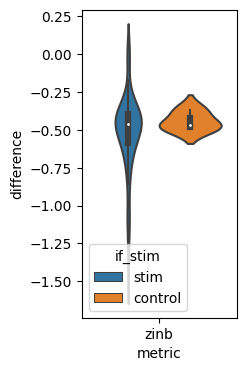

In [37]:
import pandas as pd
import seaborn as sns

print(differece0)

df=pd.DataFrame({'difference':differece0, 'if_stim':if_stim0, 'metric':metric0})
plt.figure(figsize=(2, 4))
df.to_csv('zinb_res.csv', index=False)

# box_plot=sns.boxplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('box-output.png')
# strip_plot=sns.stripplot(data=df,x="metric", y="difference",c='r', hue="if_stim")
# plt.savefig('strip-output.png')
violin_plot=sns.violinplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('violin-output1.png')


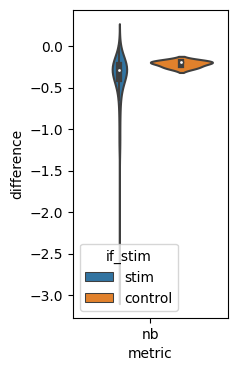

In [39]:
import pandas as pd
import seaborn as sns
df=pd.DataFrame({'difference':differece1, 'if_stim':if_stim1, 'metric':metric1})
plt.figure(figsize=(2, 4))
df.to_csv('nb_res.csv', index=False)

# print(df['difference'])
# box_plot=sns.boxplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('box-output.png')
# strip_plot=sns.stripplot(data=df,x="metric", y="difference",c='r', hue="if_stim")
# plt.savefig('strip-output.png')
violin_plot=sns.violinplot(data=df,x="metric", y="difference", hue="if_stim")
# plt.savefig('violin-output2.png')


3.140000104904175
